In [17]:
import os
import tempfile

import numpy as np
from sklearn.decomposition import PCA
#from sklearn.manifold import Isomap
from sklearn.preprocessing import MinMaxScaler
from sklearn.model_selection import train_test_split
from matplotlib import cm
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from tensorflow import keras

pdf = pd.DataFrame
import model
from model import CalculateFeatures, SelectFeatures
%matplotlib qt

In [2]:

#delete cached features to generate new features
if model.features_in_cache():
    features = model.load_features_from_cache()
else:
    df = model.load_data('../../data/DATA_3_south.csv')
    df_model = CalculateFeatures(df, 100, trim_features=True, mag_threshold=6)
    features = df_model.features
    features.to_csv("../../model/features_cache/features.csv", index=False)
features.sort_values('nextDMaxMag',inplace=True)

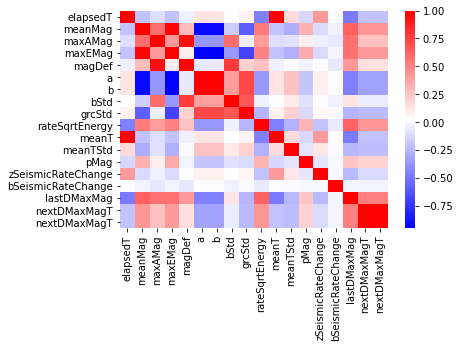

In [3]:
%matplotlib inline
X = features[model.FEATURES]
Y_CONTINUOUS = features[model.TARGETS.CONTINUOUS]
Y_CATEGORICAL = features[model.TARGETS.CATEGORICAL]
selected_features = SelectFeatures(features=X, targets=Y_CONTINUOUS, corr_threshold=.95, fixed_features=["b"])
X = X.to_numpy()
Y_CONTINUOUS = Y_CONTINUOUS.to_numpy()
Y_CATEGORICAL = Y_CATEGORICAL.to_numpy()
corrMatrix = features[model.ALL_FEATURES].corr()
sns.heatmap(corrMatrix,  cmap="bwr")
plt.show()

In [4]:
Y_CONTINUOUS_Scaler = MinMaxScaler()
X_Scaler = MinMaxScaler()
X_norm64 = X_Scaler.fit_transform(X)
Y_CONTINUOUS_norm64 = Y_CONTINUOUS_Scaler.fit_transform(Y_CONTINUOUS)
X_norm32 = X_norm64.astype(np.float32)
Y_CONTINUOUS_norm32 = Y_CONTINUOUS.astype(np.float32)


In [5]:
cmap = cm.get_cmap("viridis")
colors_continuous = list(map(cmap, Y_CONTINUOUS_norm64.T[0]))
color_categorical = list(map(cmap, Y_CATEGORICAL.T[0]*.90))
sizes = np.power(10, Y_CONTINUOUS_norm64.T[0])

In [57]:
RANDOM_STATE=42
X_norm_32_train, X_norm_32_test, Y_CONTINUOUS_norm32_train, Y_CONTINUOUS_norm32_test, Y_CATEGORICAL_train, Y_CATEGORICAL_test = train_test_split(
X_norm32, Y_CONTINUOUS_norm32, Y_CATEGORICAL, test_size=0.33, random_state=RANDOM_STATE)
X_norm_32_train, X_norm_32_val, Y_CONTINUOUS_norm32_train, Y_CONTINUOUS_norm32_val , Y_CATEGORICAL_train,Y_CATEGORICAL_val =train_test_split(X_norm_32_train, Y_CONTINUOUS_norm32_train, Y_CATEGORICAL_train, test_size=0.33, random_state=RANDOM_STATE)


Y_CATEGORICAL_test

array([[False],
       [False],
       [False],
       ...,
       [False],
       [ True],
       [False]])

'\npca = PCA(n_components=2)\npca.fit(X_norm64.T, Y_CONTINUOUS_norm64.T)\npca_components = pca.components_\n\n%matplotlib qt\nplt.scatter(pca_components[0], pca_components[1], s=sizes, color=color_categorical)\n'

In [11]:
import tensorflow as tf

METRICS = [
      keras.metrics.TruePositives(name='tp'),
      keras.metrics.FalsePositives(name='fp'),
      keras.metrics.TrueNegatives(name='tn'),
      keras.metrics.FalseNegatives(name='fn'),
      keras.metrics.BinaryAccuracy(name='accuracy'),
      keras.metrics.Precision(name='precision'),
      keras.metrics.Recall(name='recall'),
      keras.metrics.AUC(name='auc'),
      keras.metrics.AUC(name='prc', curve='PR'), # precision-recall curve
]

def make_model(metrics=METRICS, output_bias=None):
  if output_bias is not None:
    output_bias = tf.keras.initializers.Constant(output_bias)
  model = keras.Sequential([
      keras.layers.Dense( 16, activation='relu',input_shape=(X_norm_32_train.shape[-1],)),
      keras.layers.Dropout(0.5),
      keras.layers.Dense(1, activation='sigmoid',
                         bias_initializer=output_bias),
  ])

  model.compile(
      optimizer=keras.optimizers.Adam(learning_rate=1e-3),
      loss=keras.losses.BinaryCrossentropy(),
      metrics=metrics)

  return model



In [19]:
model = make_model()
model.summary()

Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_4 (Dense)              (None, 16)                272       
_________________________________________________________________
dropout_2 (Dropout)          (None, 16)                0         
_________________________________________________________________
dense_5 (Dense)              (None, 1)                 17        
Total params: 289
Trainable params: 289
Non-trainable params: 0
_________________________________________________________________


In [20]:
model.predict(X_norm_32_train[:10])

initial_weights = os.path.join(tempfile.mkdtemp(), 'initial_weights')
model.save_weights(initial_weights)

In [61]:
colors = plt.rcParams['axes.prop_cycle'].by_key()['color']
def plot_metrics(history):
  metrics = ['loss', 'prc', 'precision', 'recall']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,2,n+1)
    plt.plot(history.epoch, history.history[metric], color=colors[0], label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],
             color=colors[0], linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    if metric == 'loss':
      plt.ylim([0, plt.ylim()[1]])
    elif metric == 'auc':
      plt.ylim([0.8,1])
    else:
      plt.ylim([0,1])

    plt.legend()

In [62]:
model = make_model()
model.load_weights(initial_weights)
baseline_history = model.fit(
    X_norm_32_train,
    Y_CATEGORICAL_train,
    batch_size=BATCH_SIZE,
    epochs=EPOCHS,
    validation_data=(X_norm_32_val, Y_CATEGORICAL_val))

Epoch 1/200
9/9 [==============================] - 2s 108ms/step - loss: 0.7432 - tp: 726.0000 - fp: 9178.0000 - tn: 14242.0000 - fn: 2079.0000 - accuracy: 0.5708 - precision: 0.0733 - recall: 0.2588 - auc: 0.4498 - prc: 0.0889 - val_loss: 0.6891 - val_tp: 88.0000 - val_fp: 2195.0000 - val_tn: 5458.0000 - val_fn: 914.0000 - val_accuracy: 0.6408 - val_precision: 0.0385 - val_recall: 0.0878 - val_auc: 0.1997 - val_prc: 0.0681
Epoch 2/200
9/9 [==============================] - 0s 24ms/step - loss: 0.6713 - tp: 401.0000 - fp: 5820.0000 - tn: 9947.0000 - fn: 1402.0000 - accurac

In [63]:
plot_metrics(baseline_history)

In [ ]:


"""
embedding = Isomap(n_jobs=-1)
X_transformed = embedding.fit_transform(X_norm32, Y_CATEGORICAL)

"""

"""
%matplotlib qt

fig, ax = plt.subplots()
num_ticks = np.round((Y_CONTINUOUS_Scaler.data_max_ - Y_CONTINUOUS_Scaler.data_min_) * 10 + 1).astype(int)[0]
labels = np.round(np.linspace(Y_CONTINUOUS_Scaler.data_min_, Y_CONTINUOUS_Scaler.data_max_, num=num_ticks).T[0], 1)
ticks = np.linspace(0, 1, num=num_ticks)[np.isin(labels, np.unique(Y_CONTINUOUS))]
cax = plt.scatter(X_transformed.T[0], X_transformed.T[1], s=sizes, color=colors_continuous)

cbar = fig.colorbar(cax, ticks=ticks)
cbar.ax.set_yticklabels(np.unique(Y_CONTINUOUS))
plt.plot()
"""

